# D209 Performance Assessment - Task 1: Classification Analysis & Task 2: Predictive Analysis
### by Bader Ale 

# ▶ Research Question
Our research questions is as follows: __Given certain patient characteristics, can we classify whether a patient is hypertensive or not__.

In [1]:
# Importing libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from IPython.core.interactiveshell import InteractiveShell # Importing so we can run multiple lines in one cell
InteractiveShell.ast_node_interactivity = "all" # Code so multiple lines in one cell can be ran simultaenously 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing original dataset
df = pd.read_csv('F:/GitHub Repos/WGU_MSDA/D209_Data Mining I/medical_clean.csv')

# ▶ Data Cleaning  

In [3]:
df.head()

,CaseOrder,Customer_id,Interaction,UID,City,State,County,Zip,Lat,Lng,Population,Area,TimeZone,Job,Children,Age,Income,Marital,Gender,ReAdmis,VitD_levels,Doc_visits,Full_meals_eaten,vitD_supp,Soft_drink,Initial_admin,HighBlood,Stroke,Complication_risk,Overweight,Arthritis,Diabetes,Hyperlipidemia,BackPain,Anxiety,Allergic_rhinitis,Reflux_esophagitis,Asthma,Services,Initial_days,TotalCharge,Additional_charges,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8
0,1,C412403,8cd49b13-f45a-4b47-a2bd-173ffa932c2f,3a83ddb66e2ae73798bdf1d705dc0932,Eva,AL,Morgan,35621,34.34960,-86.72508,2951,Suburban,America/Chicago,"Psychologist, sport and exercise",1,53,86575.93,Divorced,Male,No,19.141466,6,0,0,No,Emergency Admission,Yes,No,Medium,No,Yes,Yes,No,Yes,Yes,Yes,No,Yes,Blood Work,10.585770,3726.702860,17939.403420,3,3,2,2,4,3,3,4
1,2,Z919181,d2450b70-0337-4406-bdbb-bc1037f1734c,176354c5eef714957d486009feabf195,Marianna,FL,Jackson,32446,30.84513,-85.22907,11303,Urban,America/Chicago,Community development worker,3,51,46805.99,Married,Female,No,18.940352,4,2,1,No,Emergency Admission,Yes,No,High,Yes,No,No,No,No,No,No,Yes,No,Intravenous,15.129562,4193.190458,17612.998120,3,4,3,4,4,4,3,3
2,3,F995323,a2057123-abf5-4a2c-abad-8ffe33512562,e19a0fa00aeda885b8a436757e889bc9,Sioux Falls,SD,Minnehaha,57110,43.54321,-96.63772,17125,Suburban,America/Chicago,Chief Executive Officer,3,53,14370.14,Widowed,Female,No,18.057507,4,1,0,No,Elective Admission,Yes,No,Medium,Yes,No,Yes,No,No,No,No,No,No,Blood Work,4.772177,2434.234222,17505.192460,2,4,4,4,3,4,3,3
3,4,A879973,1dec528d-eb34-4079-adce-0d7a40e82205,cd17d7b6d152cb6f23957346d11c3f07,New Richland,MN,Waseca,56072,43.89744,-93.51479,2162,Suburban,America/Chicago,Early years teacher,0,78,39741.49,Married,Male,No,16.576858,4,1,0,No,Elective Admission,No,Yes,Medium,No,Yes,No,No,No,No,No,Yes,Yes,Blood Work,1.714879,2127.830423,12993.437350,3,5,5,3,4,5,5,5
4,5,C544523,5885f56b-d6da-43a3-8760-83583af94266,d2f0425877b10ed6bb381f3e2579424a,West Point,VA,King William,23181,37.59894,-76.88958,5287,Rural,America/New_York,Health promotion specialist,1,22,1209.56,Widowed,Female,No,17.439069,5,0,2,Yes,Elective Admission,No,No,Low,No,No,No,Yes,No,No,Yes,No,No,CT Scan,1.254807,2113.073274,3716.525786,2,1,3,3,5,3,4,3


In [4]:
df.drop(['CaseOrder','Customer_id','Interaction', 'UID', 'City', 'State', 
        'County', 'Zip', 'Lat', 'Lng', 'Population', 'TimeZone', 'Job', 
        'Children','ReAdmis', 'Full_meals_eaten','vitD_supp', 'Soft_drink',
        'Additional_charges', 'Item1', 'Item2', 'Item3', 'Item4', 'Item5',
        'Item6', 'Item7', 'Item8'], axis=1, inplace=True) 

In [5]:
df.head()

,Area,Age,Income,Marital,Gender,VitD_levels,Doc_visits,Initial_admin,HighBlood,Stroke,Complication_risk,Overweight,Arthritis,Diabetes,Hyperlipidemia,BackPain,Anxiety,Allergic_rhinitis,Reflux_esophagitis,Asthma,Services,Initial_days,TotalCharge
0,Suburban,53,86575.93,Divorced,Male,19.141466,6,Emergency Admission,Yes,No,Medium,No,Yes,Yes,No,Yes,Yes,Yes,No,Yes,Blood Work,10.585770,3726.702860
1,Urban,51,46805.99,Married,Female,18.940352,4,Emergency Admission,Yes,No,High,Yes,No,No,No,No,No,No,Yes,No,Intravenous,15.129562,4193.190458
2,Suburban,53,14370.14,Widowed,Female,18.057507,4,Elective Admission,Yes,No,Medium,Yes,No,Yes,No,No,No,No,No,No,Blood Work,4.772177,2434.234222
3,Suburban,78,39741.49,Married,Male,16.576858,4,Elective Admission,No,Yes,Medium,No,Yes,No,No,No,No,No,Yes,Yes,Blood Work,1.714879,2127.830423
4,Rural,22,1209.56,Widowed,Female,17.439069,5,Elective Admission,No,No,Low,No,No,No,Yes,No,No,Yes,No,No,CT Scan,1.254807,2113.073274


## Detection and Treatment of Nulls

In [6]:
# Checking for null values
df.isnull().sum()

Area                  0
Age                   0
Income                0
Marital               0
Gender                0
VitD_levels           0
Doc_visits            0
Initial_admin         0
HighBlood             0
Stroke                0
Complication_risk     0
Overweight            0
Arthritis             0
Diabetes              0
Hyperlipidemia        0
BackPain              0
Anxiety               0
Allergic_rhinitis     0
Reflux_esophagitis    0
Asthma                0
Services              0
Initial_days          0
TotalCharge           0
dtype: int64

## Detection and Treatment of Duplicated Values

In [7]:
# Checking for duplicates
df.duplicated().value_counts()

False    10000
Name: count, dtype: int64

## Detection and Treatment of Outliers

In [8]:
df.dtypes

Area                   object
Age                     int64
Income                float64
Marital                object
Gender                 object
VitD_levels           float64
Doc_visits              int64
Initial_admin          object
HighBlood              object
Stroke                 object
Complication_risk      object
Overweight             object
Arthritis              object
Diabetes               object
Hyperlipidemia         object
BackPain               object
Anxiety                object
Allergic_rhinitis      object
Reflux_esophagitis     object
Asthma                 object
Services               object
Initial_days          float64
TotalCharge           float64
dtype: object

In [9]:
# Scaling data to make it easier to visualize outliers
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(df[['Age', 'Income', 'VitD_levels', 'Doc_visits', 'Initial_days', 'TotalCharge']])
df_scaled = pd.DataFrame(scaler.fit_transform(df[['Age', 'Income', 'VitD_levels', 'Doc_visits', 'Initial_days', 'TotalCharge']]),
                         columns=['Age', 'Income', 'VitD_levels', 'Doc_visits', 'Initial_days', 'TotalCharge'])

MinMaxScaler()

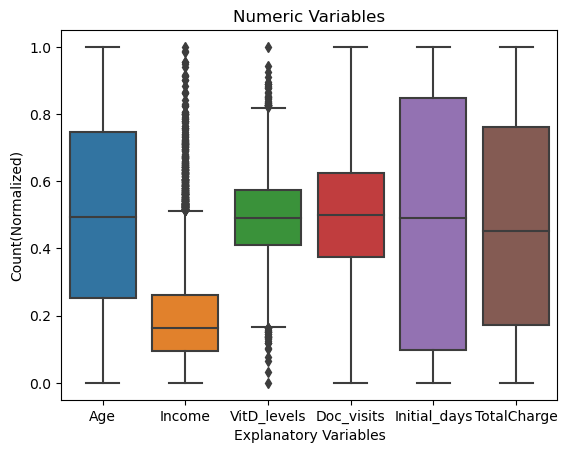

In [10]:
# Visualizing Outliers
sns.boxplot(df_scaled)
plt.title('Numeric Variables')
plt.ylabel('Count(Normalized)')
plt.xlabel('Explanatory Variables');

In [11]:
# Removing Outliers using z-scores
import scipy.stats as stats

#Creating New columns for z-scores
df['Income_z_Scores'] = stats.zscore(df['Income'])
df['VitD_level_z_Scores'] = stats.zscore(df['VitD_levels'])

# Removing records with z-scores -3 < z < 3
df = df[(df['Income_z_Scores'] > -3) & (df['Income_z_Scores'] < 3) & (df['VitD_level_z_Scores'] > -3) & (df['VitD_level_z_Scores'] < 3)]
df.drop(['Income_z_Scores', 'VitD_level_z_Scores'], axis=1, inplace=True)

In [12]:
df.head()

,Area,Age,Income,Marital,Gender,VitD_levels,Doc_visits,Initial_admin,HighBlood,Stroke,Complication_risk,Overweight,Arthritis,Diabetes,Hyperlipidemia,BackPain,Anxiety,Allergic_rhinitis,Reflux_esophagitis,Asthma,Services,Initial_days,TotalCharge
0,Suburban,53,86575.93,Divorced,Male,19.141466,6,Emergency Admission,Yes,No,Medium,No,Yes,Yes,No,Yes,Yes,Yes,No,Yes,Blood Work,10.585770,3726.702860
1,Urban,51,46805.99,Married,Female,18.940352,4,Emergency Admission,Yes,No,High,Yes,No,No,No,No,No,No,Yes,No,Intravenous,15.129562,4193.190458
2,Suburban,53,14370.14,Widowed,Female,18.057507,4,Elective Admission,Yes,No,Medium,Yes,No,Yes,No,No,No,No,No,No,Blood Work,4.772177,2434.234222
3,Suburban,78,39741.49,Married,Male,16.576858,4,Elective Admission,No,Yes,Medium,No,Yes,No,No,No,No,No,Yes,Yes,Blood Work,1.714879,2127.830423
4,Rural,22,1209.56,Widowed,Female,17.439069,5,Elective Admission,No,No,Low,No,No,No,Yes,No,No,Yes,No,No,CT Scan,1.254807,2113.073274


# ▶ Data Wrangling  

In [13]:
df.dtypes

Area                   object
Age                     int64
Income                float64
Marital                object
Gender                 object
VitD_levels           float64
Doc_visits              int64
Initial_admin          object
HighBlood              object
Stroke                 object
Complication_risk      object
Overweight             object
Arthritis              object
Diabetes               object
Hyperlipidemia         object
BackPain               object
Anxiety                object
Allergic_rhinitis      object
Reflux_esophagitis     object
Asthma                 object
Services               object
Initial_days          float64
TotalCharge           float64
dtype: object

In [14]:
# Using .get_dummies() to re-express nominal variables
df = pd.get_dummies(data=df, columns=['Area','Marital','Gender', 'Initial_admin','HighBlood',
                                      'Stroke','Overweight', 'Arthritis','Diabetes', 'Hyperlipidemia', 
                                      'BackPain', 'Anxiety', 'Allergic_rhinitis','Reflux_esophagitis', 
                                      'Asthma','Services'], drop_first=True)

In [15]:
# Using Ordinal Encoding for ordinal variables
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()
complication_encoded = enc.fit_transform(df[['Complication_risk']])
df['Complication_risk'] = complication_encoded

In [16]:
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [17]:
df.head()

,Age,Income,VitD_levels,Doc_visits,Complication_risk,Initial_days,TotalCharge,Area_Suburban,Area_Urban,Marital_Married,Marital_Never Married,Marital_Separated,Marital_Widowed,Gender_Male,Gender_Nonbinary,Initial_admin_Emergency Admission,Initial_admin_Observation Admission,HighBlood_Yes,Stroke_Yes,Overweight_Yes,Arthritis_Yes,Diabetes_Yes,Hyperlipidemia_Yes,BackPain_Yes,Anxiety_Yes,Allergic_rhinitis_Yes,Reflux_esophagitis_Yes,Asthma_Yes,Services_CT Scan,Services_Intravenous,Services_MRI
0,0.492958,0.686851,0.599171,0.625,1.0,0.135022,0.246933,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0.464789,0.370773,0.582377,0.375,0.0,0.199037,0.311343,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.492958,0.112984,0.508653,0.375,1.0,0.053117,0.068475,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.845070,0.314627,0.385009,0.375,1.0,0.010044,0.026168,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,0.056338,0.008389,0.457010,0.500,0.5,0.003562,0.024130,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [18]:
# Exporting cleaned dataset
cleaned_dataset = df.to_csv('cleaned_dataset.csv', index = False)

# ▶ Classification Analysis using k-Nearest Neighbor

In [19]:
X = df.drop('HighBlood_Yes', axis=1)
y = df['HighBlood_Yes']

In [20]:
X.head()

,Age,Income,VitD_levels,Doc_visits,Complication_risk,Initial_days,TotalCharge,Area_Suburban,Area_Urban,Marital_Married,Marital_Never Married,Marital_Separated,Marital_Widowed,Gender_Male,Gender_Nonbinary,Initial_admin_Emergency Admission,Initial_admin_Observation Admission,Stroke_Yes,Overweight_Yes,Arthritis_Yes,Diabetes_Yes,Hyperlipidemia_Yes,BackPain_Yes,Anxiety_Yes,Allergic_rhinitis_Yes,Reflux_esophagitis_Yes,Asthma_Yes,Services_CT Scan,Services_Intravenous,Services_MRI
0,0.492958,0.686851,0.599171,0.625,1.0,0.135022,0.246933,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0.464789,0.370773,0.582377,0.375,0.0,0.199037,0.311343,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.492958,0.112984,0.508653,0.375,1.0,0.053117,0.068475,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.845070,0.314627,0.385009,0.375,1.0,0.010044,0.026168,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,0.056338,0.008389,0.457010,0.500,0.5,0.003562,0.024130,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [21]:
y.head()

0    1.0
1    1.0
2    1.0
3    0.0
4    0.0
Name: HighBlood_Yes, dtype: float64

In [22]:
# Splitting data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, stratify=y)

In [23]:
# Exporting train and test data to CSV
X_train.to_csv('X_Train.csv',index=False)
X_test.to_csv('X_Test.csv', index=False)
np.savetxt('y_train.csv', y_train, delimiter=",", header="HighBlood_Yes", fmt="%.2f", comments="")
np.savetxt('y_test.csv', y_test, delimiter=",", header="HighBlood_Yes", fmt="%.2f", comments="")

In [24]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [25]:
knn.predict(X_test.values)

array([1., 1., 0., ..., 0., 0., 0.])

In [26]:
print(f'The prediction score for the model is: {knn.score(X_test.values, y_test)}')

The prediction score for the model is: 0.5223728813559322


In [27]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

#print(f'Confusion Matrix: \n{confusion_matrix(y_test,knn.predict(X_test))}')
print(f'\nClassification Report for the Model: \n{classification_report(y_test, knn.predict(X_test.values))}')
print(f'\nThe area under the curve (AUC) is: {roc_auc_score(y_test, knn.predict(X_test.values))}')



Classification Report for the Model: 
              precision    recall  f1-score   support

         0.0       0.59      0.63      0.61      1743
         1.0       0.41      0.37      0.39      1207

    accuracy                           0.52      2950
   macro avg       0.50      0.50      0.50      2950
weighted avg       0.52      0.52      0.52      2950


The area under the curve (AUC) is: 0.49874180114944333


# ▶ Predictive Analysis using Decision Trees

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Define a range of values for max_depth to test
max_depths = range(1, 10)

# Loop over max_depth values and evaluate model performance
best_accuracy = 0
best_max_depth = 0

for max_depth in max_depths:
    # Train a DecisionTreeClassifier model with current max_depth
    clf = DecisionTreeClassifier(max_depth=max_depth)
    clf.fit(X_train, y_train)
    
    # Make predictions on test set and calculate accuracy
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Update best accuracy and max_depth if current model is better
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_max_depth = max_depth

# Print best max_depth and corresponding accuracy
print("Best Max_Depth:", best_max_depth)
print("Accuracy:", best_accuracy)

DecisionTreeClassifier(max_depth=1)

DecisionTreeClassifier(max_depth=2)

DecisionTreeClassifier(max_depth=3)

DecisionTreeClassifier(max_depth=4)

DecisionTreeClassifier(max_depth=5)

DecisionTreeClassifier(max_depth=6)

DecisionTreeClassifier(max_depth=7)

DecisionTreeClassifier(max_depth=8)

DecisionTreeClassifier(max_depth=9)

Best Max_Depth: 7
Accuracy: 0.5972881355932204


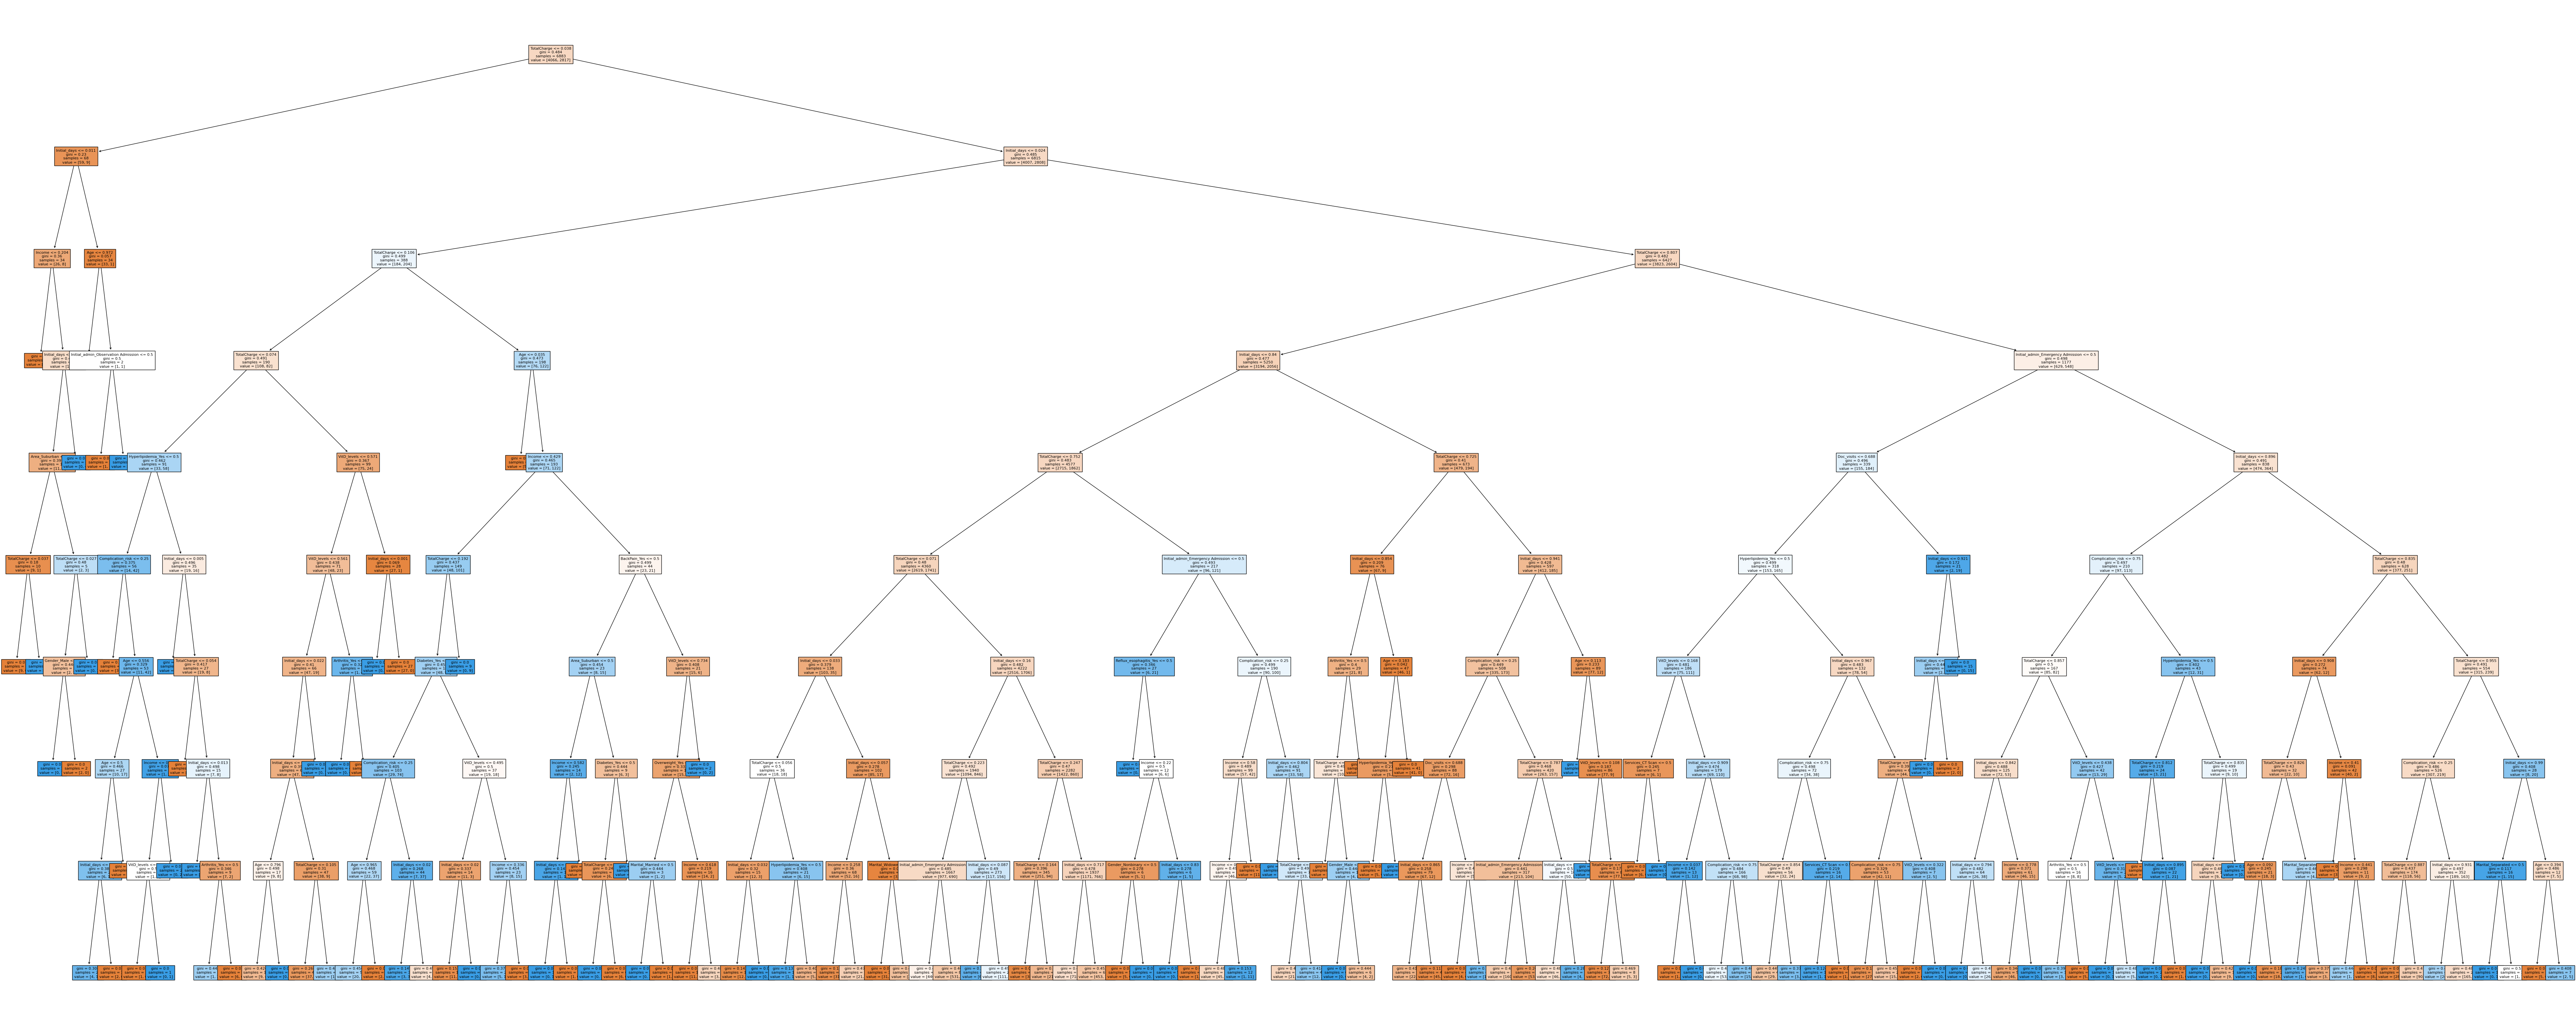

In [29]:
# Visualizing Decision Tree
from sklearn import tree
plt.figure(figsize=(100,40))
tree.plot_tree(clf,filled=True, feature_names=X.columns.to_list(),fontsize=8);